<a href="https://colab.research.google.com/github/Mjoe00/Behaviour-Intention-Gap/blob/Master/Gap.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [125]:
from google.colab import files
import pickle
import matplotlib.pyplot as plt
import numpy as np
import datetime
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import pearsonr
import seaborn as sn
import re
import xlwt
from xlwt import Workbook
import copy

In [2]:
from scipy import stats

import statsmodels.api as sm
from statsmodels.stats import diagnostic as diag
from statsmodels.stats.outliers_influence import variance_inflation_factor

from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error

%matplotlib inline

/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [3]:
from google.colab import drive

drive.mount('/content/gdrive')

f=open('/content/gdrive/MyDrive/ColabNotebooks/app_data_sept.pkl','rb')
data=pickle.load(f)

Mounted at /content/gdrive


# Exploring the data: comparing current to previous day (does not account for missed days)




In [ ]:
#initializing some variables and a dictionary
DailyGoals={'DAILY_specific_past24_sleep':[],
 'DAILY_specific_past24_jobSchool':[],
 'DAILY_specific_past24_unpaidWork':[],
 'DAILY_specific_past24_leisureSolo':[],
 'DAILY_specific_past24_leisureNonSolo':[],
 'DAILY_specific_past24_exercise':[],
 'DAILY_specific_past24_drinks':[],
 'DAILY_specific_next24_sleep':[],
 'DAILY_specific_next24_jobSchool':[],
 'DAILY_specific_next24_unpaidWork':[],
 'DAILY_specific_next24_leisureSolo':[],
 'DAILY_specific_next24_leisureNonSolo':[],
 'DAILY_specific_next24_exercise':[],
 'DAILY_specific_next24_drinks':[]
    
}
#this variable will be used for indexing
GoalsIdentifier = []


In [ ]:
#looping to extract the result keys for easier indexing later
for i in range(len(data['SurveyQuestionResults']['ResultIdentifier'])):
  if data['SurveyQuestionResults']['SurveyResultKey'][i] == "3d37a112-db15-ec11-aab0-0afb9334277d" and data['SurveyQuestionResults']['ParticipantIdentifier'][i] == "ff6860f4-c110-4545-9297-95f8888d2e03":
    GoalsIdentifier.append(data['SurveyQuestionResults']['ResultIdentifier'][i])
    
SetGoalsIdentifier = GoalsIdentifier[14:]
GoalsIdentifier = GoalsIdentifier[:14]
SetGoalsIdentifier

['DAILY_goal_report1',
 'DAILY_goal_report2',
 'DAILY_goal_set1',
 'DAILY_goal_set1_importance',
 'DAILY_goal_set1_consequences',
 'DAILY_goal_set1_motivationInternal',
 'DAILY_goal_set1_motivationExternal',
 'DAILY_goal_set2',
 'DAILY_goal_set2_importance',
 'DAILY_goal_set2_consequences',
 'DAILY_goal_set2_motivationInternal',
 'DAILY_goal_set2_motivationExternal']

In [ ]:
#looping to exract all the specific data points and sorting them into their respective key
for i in range(len(data['SurveyQuestionResults']['ResultIdentifier'][:14500])):
  for j in range(len(GoalsIdentifier)):
    if data['SurveyQuestionResults']['ResultIdentifier'][i] == GoalsIdentifier[j] and data['SurveyQuestionResults']['ParticipantIdentifier'][i] == "ff6860f4-c110-4545-9297-95f8888d2e03":
      DailyGoals[GoalsIdentifier[j]].append(float(data['SurveyQuestionResults']['Answers'][i]))

#checking the length of each to make sure there is no missing data
for j in range(len(GoalsIdentifier)):
  print(len(DailyGoals[GoalsIdentifier[j]]))
  print(GoalsIdentifier[j])



83
DAILY_specific_past24_sleep
83
DAILY_specific_past24_jobSchool
83
DAILY_specific_past24_unpaidWork
83
DAILY_specific_past24_leisureSolo
83
DAILY_specific_past24_leisureNonSolo
83
DAILY_specific_past24_exercise
83
DAILY_specific_past24_drinks
83
DAILY_specific_next24_sleep
83
DAILY_specific_next24_jobSchool
83
DAILY_specific_next24_unpaidWork
83
DAILY_specific_next24_leisureSolo
83
DAILY_specific_next24_leisureNonSolo
83
DAILY_specific_next24_exercise
83
DAILY_specific_next24_drinks


In [ ]:
#trimming the first inputed pervious goals as they might intervene(this is wrong, i am neglecting other peoples stuff)
for x in range(len(GoalsIdentifier)-7):
  DailyGoals[GoalsIdentifier[x]] = DailyGoals[GoalsIdentifier[x]][:-1]

#trimming the last inputed next goals as they are inimportant(also wrong)
for x in range(len(GoalsIdentifier)-7):
  DailyGoals[GoalsIdentifier[x+7]] = DailyGoals[GoalsIdentifier[x+7]][1:]

In [ ]:
#checking the length again to confirm they have been deleted correctly
for j in range(len(GoalsIdentifier)):
  print(len(DailyGoals[GoalsIdentifier[j]]))
  print(GoalsIdentifier[j])

82
DAILY_specific_past24_sleep
82
DAILY_specific_past24_jobSchool
82
DAILY_specific_past24_unpaidWork
82
DAILY_specific_past24_leisureSolo
82
DAILY_specific_past24_leisureNonSolo
82
DAILY_specific_past24_exercise
82
DAILY_specific_past24_drinks
82
DAILY_specific_next24_sleep
82
DAILY_specific_next24_jobSchool
82
DAILY_specific_next24_unpaidWork
82
DAILY_specific_next24_leisureSolo
82
DAILY_specific_next24_leisureNonSolo
82
DAILY_specific_next24_exercise
82
DAILY_specific_next24_drinks


In [ ]:
#initializing percent arrays
PercentSleep = []
PercentjobSchool = []
PercentunpaidWork = []
PercentleisureSolo = []
PercentleisureNonSolo = []
Percentexercise = []
Percentdrinks = []


#converting the data into percentage goals
for (prev, next) in zip(DailyGoals['DAILY_specific_past24_sleep'], DailyGoals['DAILY_specific_next24_sleep']):
    PercentSleep.append(np.divide(prev,next,where=next>0)*100)
for (prev, next) in zip(DailyGoals['DAILY_specific_past24_jobSchool'], DailyGoals['DAILY_specific_next24_jobSchool']):
    PercentjobSchool.append(np.divide(prev,next,where=next>0)*100)
for (prev, next) in zip(DailyGoals['DAILY_specific_past24_unpaidWork'], DailyGoals['DAILY_specific_next24_unpaidWork']):
    PercentunpaidWork.append(np.divide(prev,next,where=next>0)*100)
for (prev, next) in zip(DailyGoals['DAILY_specific_past24_leisureSolo'], DailyGoals['DAILY_specific_next24_leisureSolo']):
    PercentleisureSolo.append(np.divide(prev,next,where=next>0)*100)
for (prev, next) in zip(DailyGoals['DAILY_specific_past24_leisureNonSolo'], DailyGoals['DAILY_specific_next24_leisureNonSolo']):
    PercentleisureNonSolo.append(np.divide(prev,next,where=next>0)*100)
for (prev, next) in zip(DailyGoals['DAILY_specific_past24_exercise'], DailyGoals['DAILY_specific_next24_exercise']):
    Percentexercise.append(np.divide(prev,next,where=next>0)*100)
for (prev, next) in zip(DailyGoals['DAILY_specific_past24_drinks'], DailyGoals['DAILY_specific_next24_drinks']):
    Percentdrinks.append(np.divide(prev,next,where=next>0)*100)



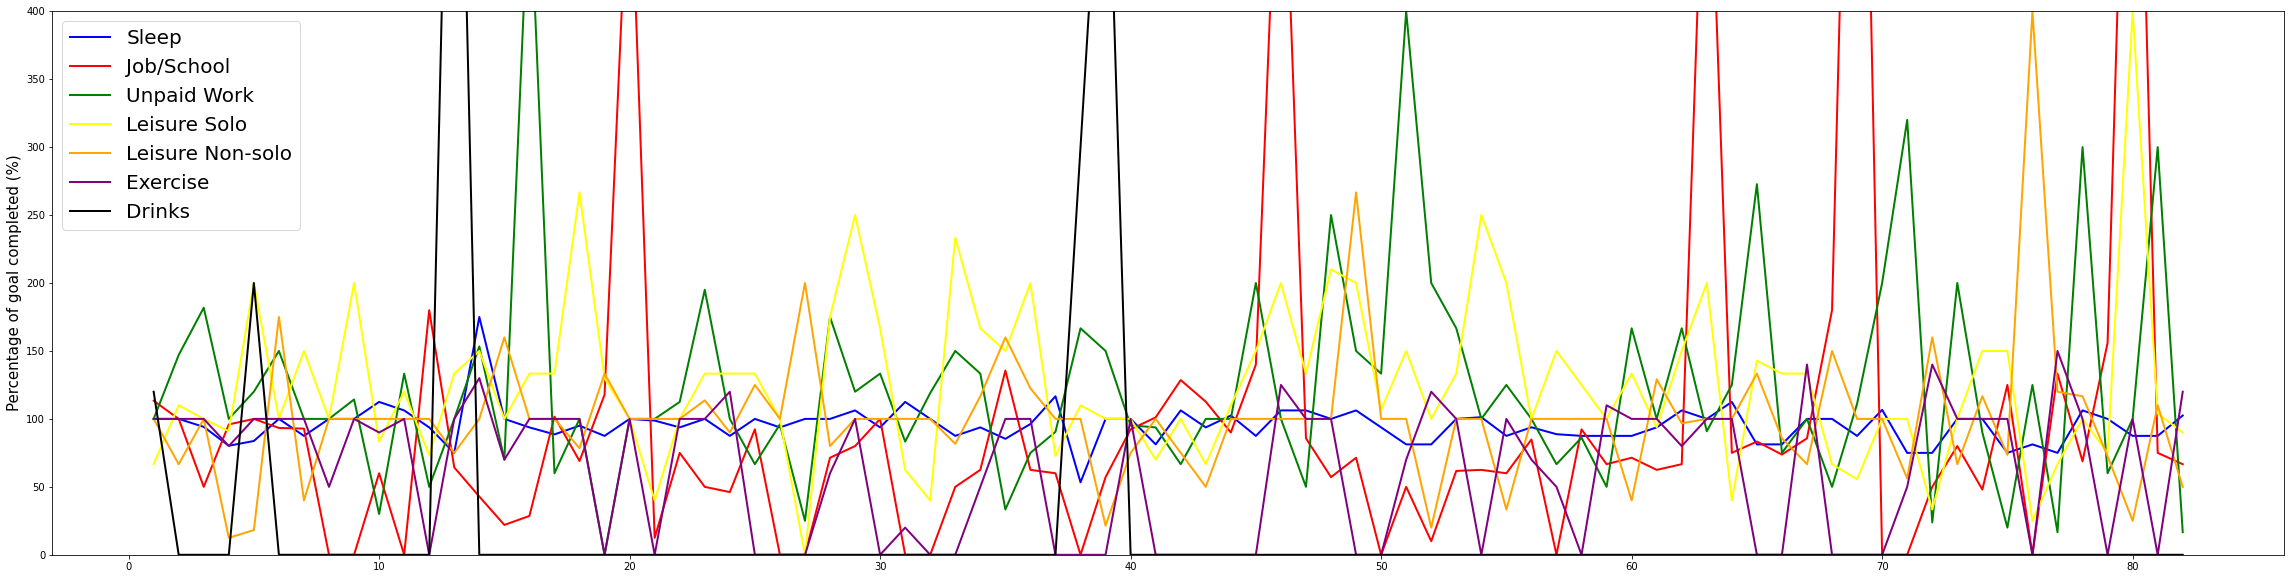

In [ ]:
#plotting the data
fig,ax = plt.subplots(1 ,figsize=(40,10))
x = list(range(1,len(PercentSleep)+1))
ax.plot(x, PercentSleep,color="blue",linewidth=2,label='Sleep')
ax.plot(x, PercentjobSchool,color="red",linewidth=2,label='Job/School')
ax.plot(x, PercentunpaidWork,color="green",linewidth=2,label='Unpaid Work')
ax.plot(x, PercentleisureSolo,color="yellow",linewidth=2,label='Leisure Solo')
ax.plot(x, PercentleisureNonSolo,color="orange",linewidth=2,label='Leisure Non-solo')
ax.plot(x, Percentexercise,color="purple",linewidth=2,label='Exercise')
ax.plot(x, Percentdrinks,color="black",linewidth=2,label='Drinks')
ax.set_ylabel('Percentage of goal completed (%)',fontsize=15)
ax.set_ylim(0,400)
ax.legend(fontsize=20)

# Exploring the data: the difference between the two daily goals and the self perceived gap (the next step should be to examine the intentions for the preset goals)

In [ ]:
#initializing variables to get daily goal info
OtherDailyGoals={'DAILY_goal_report1':[],
 'DAILY_goal_report2':[],
 'DAILY_goal_set1':[],
 'DAILY_goal_set1_importance':[],
 'DAILY_goal_set1_consequences':[],
 'DAILY_goal_set1_motivationInternal':[],
 'DAILY_goal_set1_motivationExternal':[],
 'DAILY_goal_set2':[],
 'DAILY_goal_set2_importance':[],
 'DAILY_goal_set2_consequences':[],
 'DAILY_goal_set2_motivationInternal':[],
 'DAILY_goal_set2_motivationExternal':[]
    
}
#looping to extract the goal data into the initialized dictionary, but only for my own data
for i in range(len(data['SurveyQuestionResults']['ResultIdentifier'][:15500])):
  for j in range(len(SetGoalsIdentifier)):
    if data['SurveyQuestionResults']['ResultIdentifier'][i] == SetGoalsIdentifier[j] and data['SurveyQuestionResults']['ParticipantIdentifier'][i] == "ff6860f4-c110-4545-9297-95f8888d2e03":
      if len(data['SurveyQuestionResults']['Answers'][i]) > 3:
        OtherDailyGoals[SetGoalsIdentifier[j]].append(data['SurveyQuestionResults']['Answers'][i])
      else:
        OtherDailyGoals[SetGoalsIdentifier[j]].append(float(data['SurveyQuestionResults']['Answers'][i]))

#checking the length of each to make sure there is no missing data
for j in range(len(SetGoalsIdentifier)):
  print(len(OtherDailyGoals[SetGoalsIdentifier[j]]))
  print(SetGoalsIdentifier[j])

83
DAILY_goal_report1
83
DAILY_goal_report2
83
DAILY_goal_set1
83
DAILY_goal_set1_importance
83
DAILY_goal_set1_consequences
83
DAILY_goal_set1_motivationInternal
83
DAILY_goal_set1_motivationExternal
83
DAILY_goal_set2
83
DAILY_goal_set2_importance
83
DAILY_goal_set2_consequences
83
DAILY_goal_set2_motivationInternal
83
DAILY_goal_set2_motivationExternal


In [ ]:
#trimming the first inputed pervious goals as they might intervene(this is wrong, i am neglecting other peoples stuff buts its fine because its isolating my own goals)

OtherDailyGoals['DAILY_goal_report1'] = OtherDailyGoals['DAILY_goal_report1'][:-1]
OtherDailyGoals['DAILY_goal_report2'] = OtherDailyGoals['DAILY_goal_report2'][:-1]

#trimming the last inputed next goals as they are inimportant(also wrong)
for x in SetGoalsIdentifier[2:]:
  OtherDailyGoals[x] = OtherDailyGoals[x][1:]

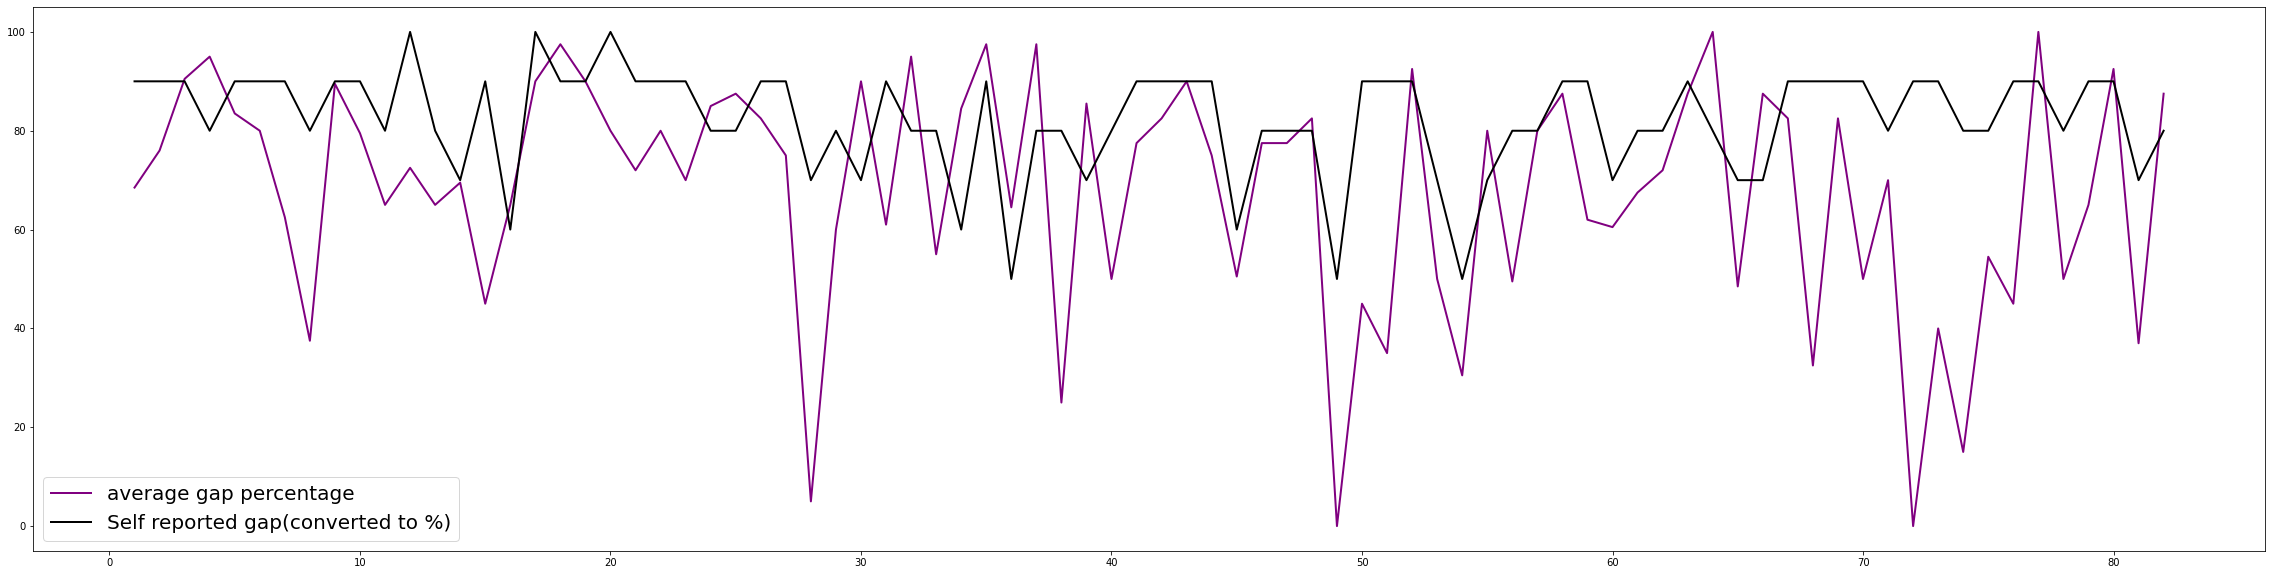

In [ ]:
#reverse coding the gap score and making it fit a percentage scale
SPgap = []
for i in gapScore:
  SPgap.append(100-(i*10))

#creating an average BI score for the two goals set each day
averageGap = []
for i in range(len(OtherDailyGoals['DAILY_goal_report1'])):
  averageGap.append((OtherDailyGoals['DAILY_goal_report1'][i] + OtherDailyGoals['DAILY_goal_report2'][i])/2)


#plotting the different gap scores against eachother
fig,ax = plt.subplots(1 ,figsize=(40,10))
x = list(range(1,len(OtherDailyGoals['DAILY_goal_report1'])+1))
#ax.plot(x, OtherDailyGoals['DAILY_goal_report1'],color="blue",linewidth=2,label='Goal 1 percentage')
#ax.plot(x, OtherDailyGoals['DAILY_goal_report2'],color="red",linewidth=2,label='Goal 2 percentage')
ax.plot(x, averageGap,color="purple",linewidth=2,label='average gap percentage')
ax.plot(x, SPgap[:-1],color="black",linewidth=2,label='Self reported gap(converted to %)')
ax.set_ylim(-5,105)
ax.legend(fontsize=20)

# Exploring the data: creating a function to test pearsons r correlations of survey results and percieved gap measure

In [ ]:
#creating a function to test pearsons r correlations of survey results and percieved gap measure
def CorrelationR(aff,id):
  AffectMeasure = []
  Gap = []

  for i in range(len(data['SurveyQuestionResults']['ResultIdentifier'])):
    if data['SurveyQuestionResults']['ResultIdentifier'][i] == aff and data['SurveyQuestionResults']['ParticipantIdentifier'][i] == id:
      AffectMeasure.append(float(data['SurveyQuestionResults']['Answers'][i]))
    if data['SurveyQuestionResults']['ResultIdentifier'][i] == 'DAILY_global_past24_gap' and data['SurveyQuestionResults']['ParticipantIdentifier'][i] == id:
      Gap.append(float(data['SurveyQuestionResults']['Answers'][i]))
  correlation, p_value = pearsonr(AffectMeasure, Gap)

  print(correlation)

In [ ]:
CorrelationR(score,'ff6860f4-c110-4545-9297-95f8888d2e03')
#'ff6860f4-c110-4545-9297-95f8888d2e03'
#'229876e0-c6b0-42b7-9d83-85f07f12eb05'



ValueError: ignored

In [ ]:
data['SurveyQuestionResults']['ParticipantIdentifier'].unique()

array(['ff6860f4-c110-4545-9297-95f8888d2e03',
       '229876e0-c6b0-42b7-9d83-85f07f12eb05',
       '01801252-3a7e-4f5f-8b6d-49e8da3902f3',
       'd26d4b78-7fcf-488e-b687-2d1c93c47b74',
       '531d7f6d-b880-4a0b-b467-80005a316f1c',
       'bcc701e1-c93e-43a1-9f2f-663423f67334',
       'aa537073-0535-401a-b9c8-7ec1c802e0d0'], dtype=object)

# Exploring the data: Creating a heatmap of all the affect variables to examine interesting correlations

In [ ]:
#initializing some variables and a dictionary
Affects={'affect_neg_frustrated':[],
 'affect_pos_relaxedCalm':[],
 'affect_neg_upset':[],
 'affect_pos_excited':[],
 'affect_neg_stressed':[],
 'affect_pos_motivated':[],
 'affect_neg_angry':[],
 'affect_pos_happy':[],
 'affect_neg_nervousAnxious':[],
 'affect_pos_focused':[],
 'affect_neg_lonelyIsolated':[],
 'affect_pos_engaged':[],
 'affect_neg_guilty':[],
 'affect_pos_hopeful':[],
 'affect_neg_sad':[],
 'affect_pos_amused':[],
 'affect_neg_bored':[],
 'affect_pos_loved':[],
 'affect_neg_lazy':[],
 'affect_pos_admired':[]
    
}
AffectIdentifier = []

#looping through one instance of the measure to get all the unique values of the affect measure
for i in range(len(data['SurveyQuestionResults']['ResultIdentifier'])):
  if data['SurveyQuestionResults']['SurveyResultKey'][i] == "fd92112c-c115-ec11-aab0-0afb9334277d":
    AffectIdentifier.append(data['SurveyQuestionResults']['ResultIdentifier'][i])

#unique values
AffectIdentifier

['affect_neg_frustrated',
 'affect_pos_relaxedCalm',
 'affect_neg_upset',
 'affect_pos_excited',
 'affect_neg_stressed',
 'affect_pos_motivated',
 'affect_neg_angry',
 'affect_pos_happy',
 'affect_neg_nervousAnxious',
 'affect_pos_focused',
 'affect_neg_lonelyIsolated',
 'affect_pos_engaged',
 'affect_neg_guilty',
 'affect_pos_hopeful',
 'affect_neg_sad',
 'affect_pos_amused',
 'affect_neg_bored',
 'affect_pos_loved',
 'affect_neg_lazy',
 'affect_pos_admired']

In [ ]:
#organizing the answers into their respective key in the affects dictionary
for i in range(len(data['SurveyQuestionResults']['ResultIdentifier'][:15720])):
  for j in range(len(AffectIdentifier)):
    if data['SurveyQuestionResults']['ResultIdentifier'][i] == AffectIdentifier[j]:
      Affects[AffectIdentifier[j]].append(int(data['SurveyQuestionResults']['Answers'][i]))

#testing the lengths of each item
for j in range(len(AffectIdentifier)):
  print(len(Affects[AffectIdentifier[j]]))


216
216
216
216
216
216
216
216
216
216
216
216
216
216
216
216
216
216
216
216


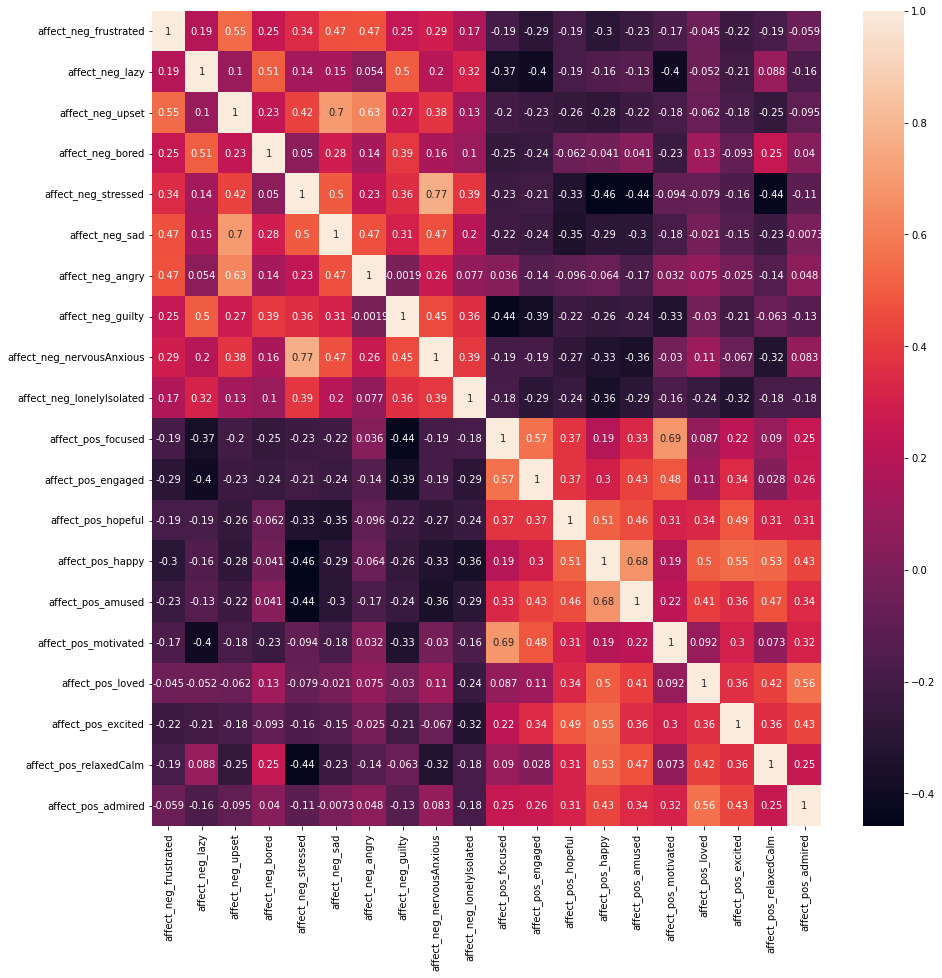

In [ ]:
#creating a heatmap
df = pd.DataFrame(Affects,columns=['affect_neg_frustrated',
 'affect_neg_lazy',
'affect_neg_upset',
 'affect_neg_bored',
 'affect_neg_stressed',
 'affect_neg_sad',
 'affect_neg_angry',
 'affect_neg_guilty',
 'affect_neg_nervousAnxious',
 'affect_neg_lonelyIsolated',
 'affect_pos_focused',
 'affect_pos_engaged',
 'affect_pos_hopeful',
 'affect_pos_happy',
 'affect_pos_amused',
 'affect_pos_motivated',
 'affect_pos_loved',
 'affect_pos_excited',
 'affect_pos_relaxedCalm',
 'affect_pos_admired'])

corrMatrix = df.corr()
fig, ax = plt.subplots(figsize=(15,15))  
ax = sn.heatmap(corrMatrix, annot=True)


# Exploring the data: comparing trail making b scores and the self reported gap

In [ ]:
score = []

for i in range(len(data['SurveyTrailmakingResults']['StartDate'])):
  if data['SurveyTrailmakingResults']['ParticipantIdentifier'][i] == "ff6860f4-c110-4545-9297-95f8888d2e03":
    placeholder = data['SurveyTrailmakingResults']['Taps'][i][-71:]
    score.append(float(re.findall("\d+\.\d+", placeholder)[0]))

SPgap = []

for i in range(len(data['SurveyQuestionResults']['Answers'])):
  if data['SurveyQuestionResults']['ParticipantIdentifier'][i] == "ff6860f4-c110-4545-9297-95f8888d2e03" and data['SurveyQuestionResults']['ResultIdentifier'][i] == "DAILY_global_past24_gap":
    SPgap.append(float(data['SurveyQuestionResults']['Answers'][i]))
score.remove(10.41172194480896)

#score = score[:]
print(len(score))
print(len(SPgap))

In [ ]:
for i in range(len(data['SurveyTrailmakingResults']['StartDate'])):
  if data['SurveyTrailmakingResults']['ParticipantIdentifier'][i] == "ff6860f4-c110-4545-9297-95f8888d2e03":
    print(data['SurveyTrailmakingResults']['StartDate'][i])

print("dhjfgbdfgbdfbg")
for i in range(len(data['SurveyQuestionResults']['Answers'])):
  if data['SurveyQuestionResults']['ParticipantIdentifier'][i] == "ff6860f4-c110-4545-9297-95f8888d2e03" and data['SurveyQuestionResults']['ResultIdentifier'][i] == "DAILY_global_past24_gap":
    print(data['SurveyQuestionResults']['StartDate'][i])

In [ ]:
fig,ax = plt.subplots(1 ,figsize=(20,10))
x = range(1,len(score)+1)
ax.plot(x, score[::-1],color="orange",linewidth=5)
for label in (ax.get_xticklabels() + ax.get_yticklabels()):
	label.set_fontsize(16)
ax.set_ylim(5,25)
ax.set_xlim(-1,85)
ax.legend(fontsize=20)
ax.set_ylabel('Time to Complete (seconds)',fontsize=25)
ax.set_xlabel('Number of Days Completed',fontsize=25)
ax.set_title('Trail Making B Over Time', size=25)

In [ ]:
print(len(score))
print(len(SPgap))
correlation, p_value = pearsonr(score, SPgap)
print(correlation)

# Data cleaning: creating a new dictionary, adding a list of dates, mapping the day of the week and mapping average scores of SR gap and trail making b

In [ ]:
#extracting everyones time to complete trail making b
data['SurveyTrailmakingResults']['TimeToComplete(s)'] = data['SurveyTrailmakingResults']['StartDate']

for i in range(len(data['SurveyTrailmakingResults']['Taps'])):
  placeholder = data['SurveyTrailmakingResults']['Taps'][i][-71:]
  data['SurveyTrailmakingResults']['TimeToComplete(s)'][i] = float(re.findall("\d+\.\d+", placeholder)[0])


realDate = np.array(data['SurveyTrailmakingResults']['StartDate'])
tmp = ""
#setting the cutoff to 4pm as if they did it in the morning or past midnight, the participant is refering to the previous day
cutoff = datetime.datetime.strptime("160000", "%H%M%S")

#looping to extract dates and convert them into manipuable numbers
#note this does not account for leap years
#this is incase someone submits past midnight or if someone does the app in the morning it will align the previous gap properly

for i in range (len(realDate)):
  if datetime.datetime.strptime(realDate[i][11:19], "%H:%M:%S") < cutoff:
    #is the day under 10 then you need an extra 0 at the beginning
    if (int(realDate[i][8:10])-1) < 10:
      #is it the first of the month?
      if (int(realDate[i][8:10])) == 1:
        #is the month under 10 then you need an extra 0 at the beginning
        if (int(realDate[i][5:7])-1) < 10:
          #is it january first?
          if (int(realDate[i][5:7])-1) == 1:
            #if the first of the year... fix the year
            realDate[i] = realDate[i][:2] + str((int(realDate[i][2:4])-1)) + realDate[i][4:]
          else:
            #if its not the first of the year but still the month is under 10... add an extra 0
            tmp = "0" + str((int(realDate[i][5:7])-1))
            realDate[i] = realDate[i][:5] + tmp + realDate[i][7:]
            #but then we must also make the day equal to the last day of the previous month... so we must correct it to 30,28, or 31...
            if int(realDate[i][5:7])-1 == 11 or int(realDate[i][5:7])-1 == 4 or int(realDate[i][5:7])-1 == 6 or int(realDate[i][5:7])-1 == 9:
              realDate[i] = realDate[i][:8] + "30"
            #correcting if the month is febuary
            elif int(realDate[i][5:7])-1 == 2:
              realDate[i] = realDate[i][:8] + "28"
            else:
              #or else just make the day 31
              realDate[i] = realDate[i][:8] + "31"

        else:
          #if the day is not the first but under 10 then correct the day...
          tmp = "0" + str((int(realDate[i][8:10])-1))
          realDate[i] = realDate[i][:8] + tmp
      
    else:
        #if the day is not even under 10 if corrected then just subtract a day
        realDate[i] = realDate[i][:8] + str((int(realDate[i][8:10])-1))
  else:
    #if its not even under the cutoff then set it to this...
    realDate[i] = realDate[i][0:10]

data['SurveyTrailmakingResults']['CorrectedDate'] = realDate

In [ ]:
data['SurveyTrailmakingResults']['CorrectedDate'][]

In [ ]:
#creating a list of all dates that will be used
newData = {"Date" : ["2021-02-10"]}

for i in range(500):
  previousDate = newData["Date"][i]
  Date = datetime.datetime.strptime(previousDate, "%Y-%m-%d") + datetime.timedelta(days=1)
  newData["Date"].append(str(Date)[:-9])

newData['Date']

In [ ]:
newData['weekday'] = [""] * len(newData['Date'])
weekdays = ['Wednesday','Thursday','Friday','Saturday','Sunday','Monday','Tuesday']
tmp = 0

for i in range(len(newData['weekday'])):
  newData['weekday'][i] = weekdays[tmp]
  if tmp != 6:
    tmp += 1
  else:
    tmp = 0

newData


In [ ]:
newData['TrailmakingB times'] = [0] * len(newData['Date'])
newData['n for each day'] = [0] * len(newData['Date'])


for x in range(len(newData['TrailmakingB times'])):
  for i in range(len(data['SurveyTrailmakingResults']['TimeToComplete(s)'])):
    if data['SurveyTrailmakingResults']['CorrectedDate'][i] == newData["Date"][x]:
      newData['TrailmakingB times'][x] = ((newData['TrailmakingB times'][x] * newData['n for each day'][x]) + data['SurveyTrailmakingResults']['TimeToComplete(s)'][i])/(newData['n for each day'][x] + 1)
      newData['n for each day'][x] = newData['n for each day'][x] + 1


In [ ]:
#trail making by weekday
weekdaytotal = [0,0,0,0,0,0,0]

tmp = 0

for z in range(len(weekdays)):
  for i in range(len(newData['TrailmakingB times'])):
    if weekdays[z] == newData['weekday'][i] and newData['TrailmakingB times'][i] != 0:
      weekdaytotal[z] = ((weekdaytotal[z] * tmp) + newData['TrailmakingB times'][i])/(tmp+1)
      tmp += 1
  tmp = 0

weekdaytotal

In [ ]:
realDate = np.array(data['SurveyQuestionResults']['StartDate'])
tmp = ""
#setting the cutoff to 4pm as if they did it in the morning or past midnight, the participant is refering to the previous day
cutoff = datetime.datetime.strptime("160000", "%H%M%S")

#looping to extract dates and convert them into manipuable numbers
#note this does not account for leap years
#this is incase someone submits past midnight or if someone does the app in the morning it will align the previous gap properly

for i in range (len(realDate)):
  if datetime.datetime.strptime(realDate[i][11:19], "%H:%M:%S") < cutoff:
    #is the day under 10 then you need an extra 0 at the beginning
    if (int(realDate[i][8:10])-1) < 10:
      #is it the first of the month?
      if (int(realDate[i][8:10])) == 1:
        #is the month under 10 then you need an extra 0 at the beginning
        if (int(realDate[i][5:7])-1) < 10:
          #is it january first?
          if (int(realDate[i][5:7])-1) == 1:
            #if the first of the year... fix the year
            realDate[i] = realDate[i][:2] + str((int(realDate[i][2:4])-1)) + realDate[i][4:]
          else:
            #if its not the first of the year but still the month is under 10... add an extra 0
            tmp = "0" + str((int(realDate[i][5:7])-1))
            realDate[i] = realDate[i][:5] + tmp + realDate[i][7:]
            #but then we must also make the day equal to the last day of the previous month... so we must correct it to 30,28, or 31...
            if int(realDate[i][5:7])-1 == 11 or int(realDate[i][5:7])-1 == 4 or int(realDate[i][5:7])-1 == 6 or int(realDate[i][5:7])-1 == 9:
              realDate[i] = realDate[i][:8] + "30"
            #correcting if the month is febuary
            elif int(realDate[i][5:7])-1 == 2:
              realDate[i] = realDate[i][:8] + "28"
            else:
              #or else just make the day 31
              realDate[i] = realDate[i][:8] + "31"

      else:
        #if the day is not the first but under 10 then correct the day...
        tmp = "0" + str((int(realDate[i][8:10])-1))
        realDate[i] = realDate[i][:8] + tmp
      
    else:
        #if the day is not even under 10 if corrected then just subtract a day
        realDate[i] = realDate[i][:8] + str((int(realDate[i][8:10])-1))
  else:
    #if its not even under the cutoff then set it to this...
    realDate[i] = realDate[i][0:10]

data['SurveyQuestionResults']['CorrectedDate'] = realDate

In [ ]:
#Extracting SR gap anwsers into the cleaned data set
newData['AverageSRgap'] = [0] * len(newData['Date'])
newData['nDaySRgap'] = [0] * len(newData['Date'])

for x in range(len(newData['AverageSRgap'])):
  for i in range(len(data['SurveyQuestionResults']['ResultIdentifier'])):
    if data['SurveyQuestionResults']['CorrectedDate'][i] == newData["Date"][x] and data['SurveyQuestionResults']['ResultIdentifier'][i] == 'DAILY_global_past24_gap':
      if float(data['SurveyQuestionResults']['Answers'][i]) == 0:
        data['SurveyQuestionResults']['Answers'][i] = 0.000001
        newData['AverageSRgap'][x] = ((newData['AverageSRgap'][x] * newData['nDaySRgap'][x]) + (float(data['SurveyQuestionResults']['Answers'][i])))/(newData['nDaySRgap'][x] + 1)
        newData['nDaySRgap'][x] = newData['nDaySRgap'][x] + 1
      else:
        newData['AverageSRgap'][x] = ((newData['AverageSRgap'][x] * newData['nDaySRgap'][x]) + (float(data['SurveyQuestionResults']['Answers'][i])))/(newData['nDaySRgap'][x] + 1)
        newData['nDaySRgap'][x] = newData['nDaySRgap'][x] + 1

newData['AverageSRgap']

In [ ]:
#SR gap by weekday
weekdaytotal = [0,0,0,0,0,0,0]

tmp = 0

for z in range(len(weekdays)):
  for i in range(len(newData['AverageSRgap'])):
    if weekdays[z] == newData['weekday'][i] and newData['AverageSRgap'][i] != 0:
      weekdaytotal[z] = ((weekdaytotal[z] * tmp) + newData['AverageSRgap'][i])/(tmp+1)
      tmp += 1
  tmp = 0

weekdaytotal


# Trail making b by participant (time to complete)

In [ ]:
data['SurveyTrailmakingResults']

In [ ]:
participantData = {'Date' : newData['Date']}

participants = data['SurveyTrailmakingResults']['ParticipantIdentifier'].unique()
for i in range(len(participants)):
  participantData[participants[i]] = 0 * len(newData['Date'])
  for x in range(len(data['SurveyTrailmakingResults']['TimeToComplete(s)'])):
    if data['SurveyTrailmakingResults']['ParticipantIdentifier'][x] == participants[i]:
      participantData[participants[i]][x] = 


# Data cleaning: writing data to a csv file

In [ ]:
newData.keys()

In [ ]:
# Workbook is created
wb = Workbook()
sheet1 = wb.add_sheet('Trail Making B')

sheet1.write(0,0, "Date")
sheet1.write(0,1, "Weekday")
sheet1.write(0,2, "Average_SR_gap")
sheet1.write(0,3, "TrailmakingB times")

for i in range(len(newData['Date'])):
  sheet1.write(i+1,0, newData['Date'][i])
  sheet1.write(i+1,1, newData['weekday'][i])
  if newData['AverageSRgap'][i] != 0:
    sheet1.write(i+1,2, round(newData['AverageSRgap'][i], 2))

  if newData['TrailmakingB times'][i] != 0:
    sheet1.write(i+1,3, round(newData['TrailmakingB times'][i], 2))
  
wb.save('cleaneddata.xls')

# Cendri's Challenge: Correlate everything from June to September

In [ ]:
# make new dictionary with only my variables organized by date

In [110]:
chall = {"Date" : ["2021-06-01"]}

for i in range(91):
  previousDate = chall["Date"][i]
  Date = datetime.datetime.strptime(previousDate, "%Y-%m-%d") + datetime.timedelta(days=1)
  chall["Date"].append(str(Date)[:-9])

len(chall['Date'])

92

In [111]:
Participant = "ff6860f4-c110-4545-9297-95f8888d2e03"
#229876e0-c6b0-42b7-9d83-85f07f12eb05
#01801252-3a7e-4f5f-8b6d-49e8da3902f3
#aa537073-0535-401a-b9c8-7ec1c802e0d0	
#ff6860f4-c110-4545-9297-95f8888d2e03

In [112]:
#initializing some variables and a dictionary
lent = ['null'] * len(chall['Date'])
challenge={'Date' : chall['Date'],
    'affect_neg_frustrated': lent.copy(),
 'affect_pos_relaxedCalm':lent.copy(),
 'affect_neg_upset':lent.copy(),
 'affect_pos_excited':lent.copy(),
 'affect_neg_stressed':lent.copy(),
 'affect_pos_motivated':lent.copy(),
 'affect_neg_angry':lent.copy(),
 'affect_pos_happy':lent.copy(),
 'affect_neg_nervousAnxious':lent.copy(),
 'affect_pos_focused':lent.copy(),
 'affect_neg_lonelyIsolated':lent.copy(),
 'affect_pos_engaged':lent.copy(),
 'affect_neg_guilty':lent.copy(),
 'affect_pos_hopeful':lent.copy(),
 'affect_neg_sad':lent.copy(),
 'affect_pos_amused':lent.copy(),
 'affect_neg_bored':lent.copy(),
 'affect_pos_loved':lent.copy(),
 'affect_neg_lazy':lent.copy(),
 'affect_pos_admired':lent.copy()
    
}
AffectIdentifier = []

#looping through one instance of the measure to get all the unique values of the affect measure
for i in range(len(data['SurveyQuestionResults']['ResultIdentifier'])):
  if data['SurveyQuestionResults']['SurveyResultKey'][i] == "fd92112c-c115-ec11-aab0-0afb9334277d":
    AffectIdentifier.append(data['SurveyQuestionResults']['ResultIdentifier'][i])

#unique values
AffectIdentifier

['affect_neg_frustrated',
 'affect_pos_relaxedCalm',
 'affect_neg_upset',
 'affect_pos_excited',
 'affect_neg_stressed',
 'affect_pos_motivated',
 'affect_neg_angry',
 'affect_pos_happy',
 'affect_neg_nervousAnxious',
 'affect_pos_focused',
 'affect_neg_lonelyIsolated',
 'affect_pos_engaged',
 'affect_neg_guilty',
 'affect_pos_hopeful',
 'affect_neg_sad',
 'affect_pos_amused',
 'affect_neg_bored',
 'affect_pos_loved',
 'affect_neg_lazy',
 'affect_pos_admired']

In [113]:
def fixdate(index):
  realDate = np.array(data[index]['StartDate'])
  tmp = ""
  #setting the cutoff to 4pm as if they did it in the morning or past midnight, the participant is refering to the previous day
  cutoff = datetime.datetime.strptime("160000", "%H%M%S")

  #looping to extract dates and convert them into manipuable numbers
  #note this does not account for leap years
  #this is incase someone submits past midnight or if someone does the app in the morning it will align the previous gap properly

  for i in range (len(realDate)):
    if datetime.datetime.strptime(realDate[i][11:19], "%H:%M:%S") < cutoff:
      #is the day under 10 then you need an extra 0 at the beginning
      if (int(realDate[i][8:10])-1) < 10:
        #is it the first of the month?
        if (int(realDate[i][8:10])) == 1:
          #is the month under 10 then you need an extra 0 at the beginning
          if (int(realDate[i][5:7])-1) < 10:
            #is it january first?
            if (int(realDate[i][5:7])-1) == 1:
              #if the first of the year... fix the year
              realDate[i] = realDate[i][0:2] + str((int(realDate[i][2:4])-1)) + realDate[i][4:10]
            else:
              #if its not the first of the year but still the month is under 10... add an extra 0
              tmp = "0" + str((int(realDate[i][5:7])-1))
              realDate[i] = realDate[i][0:5] + tmp + realDate[i][7:10]
              #but then we must also make the day equal to the last day of the previous month... so we must correct it to 30,28, or 31...
              if int(realDate[i][5:7])-1 == 11 or int(realDate[i][5:7])-1 == 4 or int(realDate[i][5:7])-1 == 6 or int(realDate[i][5:7])-1 == 9:
                realDate[i] = realDate[i][0:8] + "30"
              #correcting if the month is febuary
              elif int(realDate[i][5:7])-1 == 2:
                realDate[i] = realDate[i][0:8] + "28"
              else:
                #or else just make the day 31
                realDate[i] = realDate[i][0:8] + "31"

        else:
          #if the day is not the first but under 10 then correct the day...
          tmp = "0" + str((int(realDate[i][8:10])-1))
          realDate[i] = realDate[i][0:8] + tmp
        
      else:
          #if the day is not even under 10 if corrected then just subtract a day
          realDate[i] = realDate[i][0:8] + str((int(realDate[i][8:10])-1))
    else:
      #if its not even under the cutoff then set it to this...
      realDate[i] = realDate[i][0:10]
  return realDate

data["SurveyQuestionResults"]['CorrectedDate'] = fixdate("SurveyQuestionResults")

In [114]:
#organizing the answers into their respective key in the affects dictionary
for i in range(len(data['SurveyQuestionResults']['Answers'])):
  for j in range(len(AffectIdentifier)):
    if data['SurveyQuestionResults']['ResultIdentifier'][i] == AffectIdentifier[j] and data['SurveyQuestionResults']['ParticipantIdentifier'][i] == Participant:
      for x in range(len(challenge['Date'])):
        if str(data['SurveyQuestionResults']['CorrectedDate'][i]) == challenge['Date'][x]:
          challenge[AffectIdentifier[j]][x] = data['SurveyQuestionResults']['Answers'][i]



Reaction time:

In [115]:
data["SurveyReactionTimeResults"]['CorrectedDate'] = fixdate("SurveyReactionTimeResults")

challenge['RT'] = lent.copy()
rtident = data['SurveyReactionTimeResults']['SurveyResultKey'].unique()
avglist = {'avg' : [0] * len(data['SurveyReactionTimeResults']['SurveyResultKey'].unique()), 'date0' : [0] * len(data['SurveyReactionTimeResults']['SurveyResultKey'].unique())}
tmp =  [0] * len(data['SurveyReactionTimeResults']['SurveyResultKey'].unique())

for i in range(len(data['SurveyReactionTimeResults']['SurveyResultKey'])):
  for j in range(len(rtident)):
    if rtident[j] == data['SurveyReactionTimeResults']['SurveyResultKey'][i] and data['SurveyReactionTimeResults']['ParticipantIdentifier'][i] == Participant:
      if avglist['avg'][j] == 0:
        avglist['avg'][j] = avglist['avg'][j] + data['SurveyReactionTimeResults']['ReactionTime'][i]
        tmp[j] = 1
      else:
        avglist['avg'][j] = ((avglist['avg'][j]*tmp[j]) + data['SurveyReactionTimeResults']['ReactionTime'][i])/(tmp[j]+1)
        tmp[j] += 1
      avglist['date0'][j] = data['SurveyReactionTimeResults']['CorrectedDate'][i]

for i in range(len(challenge['RT'])):
  for x in range(len(avglist['date0'])):
    if challenge['Date'][i] == avglist["date0"][x]:
      challenge['RT'][i] = avglist['avg'][x] 




Tower of Hanoi

In [116]:
data["SurveyTowerOfHanoiResults"]['CorrectedDate'] = fixdate("SurveyTowerOfHanoiResults")

score = []

for i in range(len(data['SurveyTowerOfHanoiResults']['StartDate'])):
    placeholder = data['SurveyTowerOfHanoiResults']['Moves'][i][-71:]
    score.append(float(re.findall("\d+\.\d+", placeholder)[0]))

data['SurveyTowerOfHanoiResults']['time'] = score

nMoves = []
tmp = 0
for i in range(len(data['SurveyTowerOfHanoiResults']['Moves'])):
  for x in range(len(data['SurveyTowerOfHanoiResults']['Moves'][i])):
    if data['SurveyTowerOfHanoiResults']['Moves'][i][x] == "{":
      tmp += 1
  nMoves.append(tmp)
  tmp = 0
data['SurveyTowerOfHanoiResults']['nMoves'] = nMoves

In [117]:
challenge['TowerTime'] = lent.copy()
challenge['TowerMoves'] = lent.copy()

for i in range(len(data['SurveyTowerOfHanoiResults']['nMoves'])):
  for x in range(len(challenge['Date'])):
    if data['SurveyTowerOfHanoiResults']['CorrectedDate'][i] == challenge['Date'][x] and data['SurveyTowerOfHanoiResults']['ParticipantIdentifier'][i] == Participant:
      challenge['TowerTime'][x] = data['SurveyTowerOfHanoiResults']['time'][i]
      challenge['TowerMoves'][x] = data['SurveyTowerOfHanoiResults']['nMoves'][i]

Trail making B

In [118]:
data["SurveyTrailmakingResults"]['CorrectedDate'] = fixdate("SurveyTrailmakingResults")

score = []

for i in range(len(data['SurveyTrailmakingResults']['StartDate'])):
    placeholder = data['SurveyTrailmakingResults']['Taps'][i][-71:]
    score.append(float(re.findall("\d+\.\d+", placeholder)[0]))

data['SurveyTrailmakingResults']['time'] = score


In [119]:
challenge['TrailTime'] = lent.copy()
challenge['TrailErrors'] = lent.copy()

for i in range(len(data['SurveyTrailmakingResults']['NumberOfErrors'])):
  for x in range(len(challenge['Date'])):
    if data['SurveyTrailmakingResults']['CorrectedDate'][i] == challenge['Date'][x] and data['SurveyTrailmakingResults']['ParticipantIdentifier'][i] == Participant:
      challenge['TrailTime'][x] = data['SurveyTrailmakingResults']['time'][i]
      challenge['TrailErrors'][x] = data['SurveyTrailmakingResults']['NumberOfErrors'][i]

Spatial Memory

In [120]:
data["SurveySpatialSpanMemoryResults"]['CorrectedDate'] = fixdate("SurveySpatialSpanMemoryResults")

challenge['SpatialMemoryScore'] = lent.copy()

for i in range(len(data['SurveySpatialSpanMemoryResults']['Score'])):
  for x in range(len(challenge['Date'])):
    if data['SurveySpatialSpanMemoryResults']['CorrectedDate'][i] == challenge['Date'][x] and data['SurveySpatialSpanMemoryResults']['ParticipantIdentifier'][i] == Participant:
      challenge['SpatialMemoryScore'][x] = data['SurveySpatialSpanMemoryResults']['Score'][i]

Serial Addition

In [121]:
data["SurveyPSATResults"]['CorrectedDate'] = fixdate("SurveyPSATResults")

challenge['PSAT'] = lent.copy()

for i in range(len(data['SurveyPSATResults']['TotalCorrect'])):
  for x in range(len(challenge['Date'])):
    if data['SurveyPSATResults']['CorrectedDate'][i] == challenge['Date'][x] and data['SurveyPSATResults']['ParticipantIdentifier'][i] == Participant:
      challenge['PSAT'][x] = data['SurveyPSATResults']['TotalCorrect'][i]

Stroop Task

In [122]:
data["SurveyStroopResults"]['CorrectedDate'] = fixdate("SurveyStroopResults")


congruent = data['SurveyStroopResults']['Color'].copy()
correct = data['SurveyStroopResults']['Color'].copy()
rt = data['SurveyStroopResults']['Color'].copy()

for i in range(len(data['SurveyStroopResults']['Color'])):
  if data['SurveyStroopResults']['Color'][i] == data['SurveyStroopResults']['Text'][i]:
    congruent[i] = True
  else:
    congruent[i] = False

  if data['SurveyStroopResults']['Color'][i] == data['SurveyStroopResults']['ColorSelected'][i]:
    correct[i] = True
  else:
    correct[i] = False
  rt[i] = (data['SurveyStroopResults']['EndTime'][i] - data['SurveyStroopResults']['StartTime'][i]) *1000

data['SurveyStroopResults']['rt'] = rt
data['SurveyStroopResults']['congruent'] = congruent
data['SurveyStroopResults']['correct'] = correct

In [123]:

numcongru = np.zeros(len(challenge['Date']))
congruavg = np.zeros(len(challenge['Date']))
numincon = np.zeros(len(challenge['Date']))
inconavg = np.zeros(len(challenge['Date']))

for i in range(len(challenge['Date'])):
  for x in range(len(data['SurveyStroopResults']['Color'])):
    if challenge['Date'][i] == data['SurveyStroopResults']['CorrectedDate'][x] and data['SurveyStroopResults']['correct'][x] == True and data['SurveyStroopResults']['ParticipantIdentifier'][x] == Participant:
      if  data['SurveyStroopResults']['congruent'][x] == True:
        congruavg[i] =  (data['SurveyStroopResults']['rt'][x] + (congruavg[i]*numcongru[i]))/(numcongru[i]+1)
        numcongru = numcongru + 1
      else:
        inconavg[i] =  (data['SurveyStroopResults']['rt'][x] + (inconavg[i]*numincon[i]))/(numincon[i]+1)
        numincon = numincon + 1

challenge['Stroopcost'] = lent.copy()
for i in range(len(challenge['Date'])):
  challenge['Stroopcost'][i] = inconavg[i] - congruavg[i]
  if challenge['Stroopcost'][i] == 0:
    challenge['Stroopcost'][i] = 'null'

Survey: self report and gap

In [124]:
l = ['null'] * len(challenge['Date'])
challenge['DAILY_specific_past24_sleep'] = l.copy()
challenge['DAILY_specific_past24_jobSchool'] = l.copy()
challenge['DAILY_specific_past24_leisureSolo'] = l.copy()
challenge['DAILY_specific_past24_leisureNonSolo'] = l.copy()
challenge['DAILY_specific_past24_exercise'] = l.copy()
challenge['DAILY_specific_past24_drinks'] = l.copy()
challenge['DAILY_specific_past24_unpaidWork'] = l.copy()
challenge['DAILY_global_past24_gap']= l.copy()

goalkey = ['DAILY_specific_past24_sleep',
 'DAILY_specific_past24_jobSchool',
 'DAILY_specific_past24_unpaidWork',
 'DAILY_specific_past24_leisureSolo',
 'DAILY_specific_past24_leisureNonSolo',
 'DAILY_specific_past24_exercise',
 'DAILY_specific_past24_drinks', 'DAILY_global_past24_gap']

for i in range(len(data['SurveyQuestionResults']['ResultIdentifier'])):
  for j in goalkey:
    for x in range(len(challenge["Date"])):
      if data['SurveyQuestionResults']['ResultIdentifier'][i] == j and data['SurveyQuestionResults']['ParticipantIdentifier'][i] == Participant and challenge["Date"][x] == data['SurveyQuestionResults']['CorrectedDate'][i]:
        challenge[j][x] = data['SurveyQuestionResults']['Answers'][i]


# Preparing for last three days heatmap and last 1 day heatmap

In [126]:
#putting date to the side for future coding
offtoside = challenge['Date'].copy()
del challenge['Date']

In [128]:
#creating copy for threedays prior heatmap
challenge3 = copy.deepcopy(challenge)


In [130]:
#creating keys for 3 days prior
w = list(challenge3.keys())
for i in w:
  challenge3[i+"_Previous3Days"] = copy.deepcopy(challenge3[i])

In [131]:
today = ['affect_neg_frustrated',
 'affect_pos_relaxedCalm',
 'affect_neg_upset',
 'affect_pos_excited',
 'affect_neg_stressed',
 'affect_pos_motivated',
 'affect_neg_angry',
 'affect_pos_happy',
 'affect_neg_nervousAnxious',
 'affect_pos_focused',
 'affect_neg_lonelyIsolated',
 'affect_pos_engaged',
 'affect_neg_guilty',
 'affect_pos_hopeful',
 'affect_neg_sad',
 'affect_pos_amused',
 'affect_neg_bored',
 'affect_pos_loved',
 'affect_neg_lazy',
 'affect_pos_admired',
 'RT',
 'TowerTime',
 'TowerMoves',
 'TrailTime',
 'TrailErrors',
 'SpatialMemoryScore',
 'PSAT',
 'Stroopcost',
 'DAILY_specific_past24_sleep',
 'DAILY_specific_past24_jobSchool',
 'DAILY_specific_past24_leisureSolo',
 'DAILY_specific_past24_leisureNonSolo',
 'DAILY_specific_past24_exercise',
 'DAILY_specific_past24_drinks',
 'DAILY_specific_past24_unpaidWork',
 'DAILY_global_past24_gap']

yesterday = ['affect_neg_frustratedYesterday',
 'affect_pos_relaxedCalmYesterday',
 'affect_neg_upsetYesterday',
 'affect_pos_excitedYesterday',
 'affect_neg_stressedYesterday',
 'affect_pos_motivatedYesterday',
 'affect_neg_angryYesterday',
 'affect_pos_happyYesterday',
 'affect_neg_nervousAnxiousYesterday',
 'affect_pos_focusedYesterday',
 'affect_neg_lonelyIsolatedYesterday',
 'affect_pos_engagedYesterday',
 'affect_neg_guiltyYesterday',
 'affect_pos_hopefulYesterday',
 'affect_neg_sadYesterday',
 'affect_pos_amusedYesterday',
 'affect_neg_boredYesterday',
 'affect_pos_lovedYesterday',
 'affect_neg_lazyYesterday',
 'affect_pos_admiredYesterday',
 'RTYesterday',
 'TowerTimeYesterday',
 'TowerMovesYesterday',
 'TrailTimeYesterday',
 'TrailErrorsYesterday',
 'SpatialMemoryScoreYesterday',
 'PSATYesterday',
 'StroopcostYesterday',
 'DAILY_specific_past24_sleepYesterday',
 'DAILY_specific_past24_jobSchoolYesterday',
 'DAILY_specific_past24_leisureSoloYesterday',
 'DAILY_specific_past24_leisureNonSoloYesterday',
 'DAILY_specific_past24_exerciseYesterday',
 'DAILY_specific_past24_drinksYesterday',
 'DAILY_specific_past24_unpaidWorkYesterday',
 'DAILY_global_past24_gapYesterday']

last3 = ['affect_neg_frustrated_Previous3Days', 
'affect_pos_relaxedCalm_Previous3Days',
'affect_neg_upset_Previous3Days', 
'affect_pos_excited_Previous3Days', 
'affect_neg_stressed_Previous3Days', 
'affect_pos_motivated_Previous3Days', 
'affect_neg_angry_Previous3Days', 
'affect_pos_happy_Previous3Days', 
'affect_neg_nervousAnxious_Previous3Days',
'affect_pos_focused_Previous3Days', 
'affect_neg_lonelyIsolated_Previous3Days', 
'affect_pos_engaged_Previous3Days', 
'affect_neg_guilty_Previous3Days', 
'affect_pos_hopeful_Previous3Days', 
'affect_neg_sad_Previous3Days', 
'affect_pos_amused_Previous3Days', 
'affect_neg_bored_Previous3Days', 
'affect_pos_loved_Previous3Days', 
'affect_neg_lazy_Previous3Days',
'affect_pos_admired_Previous3Days', 
'RT_Previous3Days', 
'TowerTime_Previous3Days', 
'TowerMoves_Previous3Days',
'TrailTime_Previous3Days',
'TrailErrors_Previous3Days',
'SpatialMemoryScore_Previous3Days',
'PSAT_Previous3Days', 
'Stroopcost_Previous3Days',
'DAILY_specific_past24_sleep_Previous3Days',
'DAILY_specific_past24_jobSchool_Previous3Days', 
'DAILY_specific_past24_leisureSolo_Previous3Days', 
'DAILY_specific_past24_leisureNonSolo_Previous3Days', 
'DAILY_specific_past24_exercise_Previous3Days', 
'DAILY_specific_past24_drinks_Previous3Days', 
'DAILY_specific_past24_unpaidWork_Previous3Days', 
'DAILY_global_past24_gap_Previous3Days']

In [132]:
#creating a function to make a previous day average
def means(listy2):
  listy = list(listy2)
  sub = 0
  if listy[0] == 'null':
    del listy[0]
    sub +=1
  else:
    listy[0] = float(listy[0])
  if listy[1-sub] == 'null':
    del listy[1-sub]
    sub +=1
  else:
    listy[1-sub] = float(listy[1-sub])
  if listy[2-sub] == 'null':
    del listy[2-sub]
  else:
    listy[2-sub] = float(listy[2-sub])

  return np.mean(listy)

In [133]:
#changing values to make it 3 days prior
number = [0,0,0]
tmp = 0
for i in range(len(last3)):
  number = [challenge3[today[i]][0],challenge3[today[i]][1],challenge3[today[i]][2]]
  for x in range(len(challenge3['DAILY_specific_past24_drinks'])-3):
    tmp = challenge3[today[i]][x+3]
    challenge3[last3[i]][x+3] = means(number)
    number[0] = number[1]
    number[1] = number[2]
    number[2] = tmp
#deleting extra values so they are the same length


{'affect_neg_frustrated': ['null', '2', '4', '3', 'null', 'null', '2', '4', '4', '2', 'null', 'null', '2', '3', '2', '4', '4', '3', '2', '2', '3', '2', '2', '3', '3', 'null', '1', '2', '3', '3', '2', '2', 'null', '2', '3', '4', '4', '3', '2', '3', '3', 'null', 'null', '3', '3', '2', '4', '2', '3', '3', '3', '2', '2', '3', '3', '3', '2', '2', 'null', '3', '2', 'null', '2', '2', '2', '3', 'null', '2', '2', '2', '2', '2', '2', 'null', '2', '2', '2', '3', '2', '2', 'null', 'null', '2', '3', 'null', 'null', '2', 'null', '2', '3', 'null', 'null'], 'affect_pos_relaxedCalm': ['null', '4', '4', '4', 'null', 'null', '2', '2', '2', '2', 'null', 'null', '4', '2', '3', '2', '4', '4', '4', '5', '3', '2', '3', '3', '4', 'null', '4', '3', '2', '3', '5', '4', 'null', '3', '2', '2', '2', '3', '4', '3', '4', 'null', 'null', '4', '3', '3', '3', '4', '3', '3', '2', '4', '4', '3', '3', '3', '4', '3', 'null', '4', '5', 'null', '3', '4', '4', '4', 'null', '4', '4', '3', '4', '4', '4', 'null', '4', '5', '4', '

In [134]:
#deleting the first three days (no data before them)
for i in list(challenge3.keys()):
  del challenge3[i][0]
  del challenge3[i][0]
  del challenge3[i][0]

# Cendri's Challenge: Creating last 3 days heatmap

In [135]:
#changing null string to numpy null equivalent
w = list(challenge3.keys())

for j in w:
  for i in range(len(challenge3['affect_neg_angry'])):
    if challenge3[j][i] == "null":
      challenge3[j][i] = np.nan
    else:
      challenge3[j][i] = float(challenge3[j][i])

In [136]:
#turning dictionary into pandas dataframe and dropping null rows
df = pd.DataFrame(challenge3,columns = list(challenge3.keys()))
df = df.dropna(how='any',axis=0) 
forco = df.to_dict()

In [ ]:
#creating the heapmap
df = pd.DataFrame(challenge3,columns = list(challenge3.keys()))
df = df.dropna(how='any',axis=0) 
corrMatrix = df.corr()
print(corrMatrix)
fig, ax = plt.subplots(figsize=(70,70))  
ax = sn.heatmap(corrMatrix, xticklabels=True, yticklabels=True,annot=True)

# Cendri's Challenge: Creating last 1 day heatmap

In [142]:
#creating copy for future use
challenge1 = copy.deepcopy(challenge)

#creating keys for 1 day prior
w = list(challenge1.keys())
for i in w:
  challenge1[i+"Yesterday"] = copy.deepcopy(challenge1[i])

In [144]:
#for the 1 previous day dataset i am making the datasets line up
for i in today:
  del challenge1[i][0]

for i in yesterday:
  del challenge1[i][91]

In [145]:
#changing null string to numpy null equivalent
w = list(challenge1.keys())

for j in w:
  for i in range(len(challenge1['affect_neg_angry'])):
    if challenge1[j][i] == "null":
      challenge1[j][i] = np.nan
    else:
      challenge1[j][i] = float(challenge1[j][i])

                                               affect_neg_frustrated  ...  DAILY_global_past24_gapYesterday
affect_neg_frustrated                                       1.000000  ...                          0.104103
affect_pos_relaxedCalm                                     -0.467036  ...                          0.026600
affect_neg_upset                                            0.469475  ...                         -0.029989
affect_pos_excited                                          0.045629  ...                          0.098267
affect_neg_stressed                                         0.621240  ...                          0.047320
...                                                              ...  ...                               ...
DAILY_specific_past24_leisureNonSoloYesterday              -0.256278  ...                         -0.213197
DAILY_specific_past24_exerciseYesterday                     0.044342  ...                         -0.093640
DAILY_specific_past24_drinks

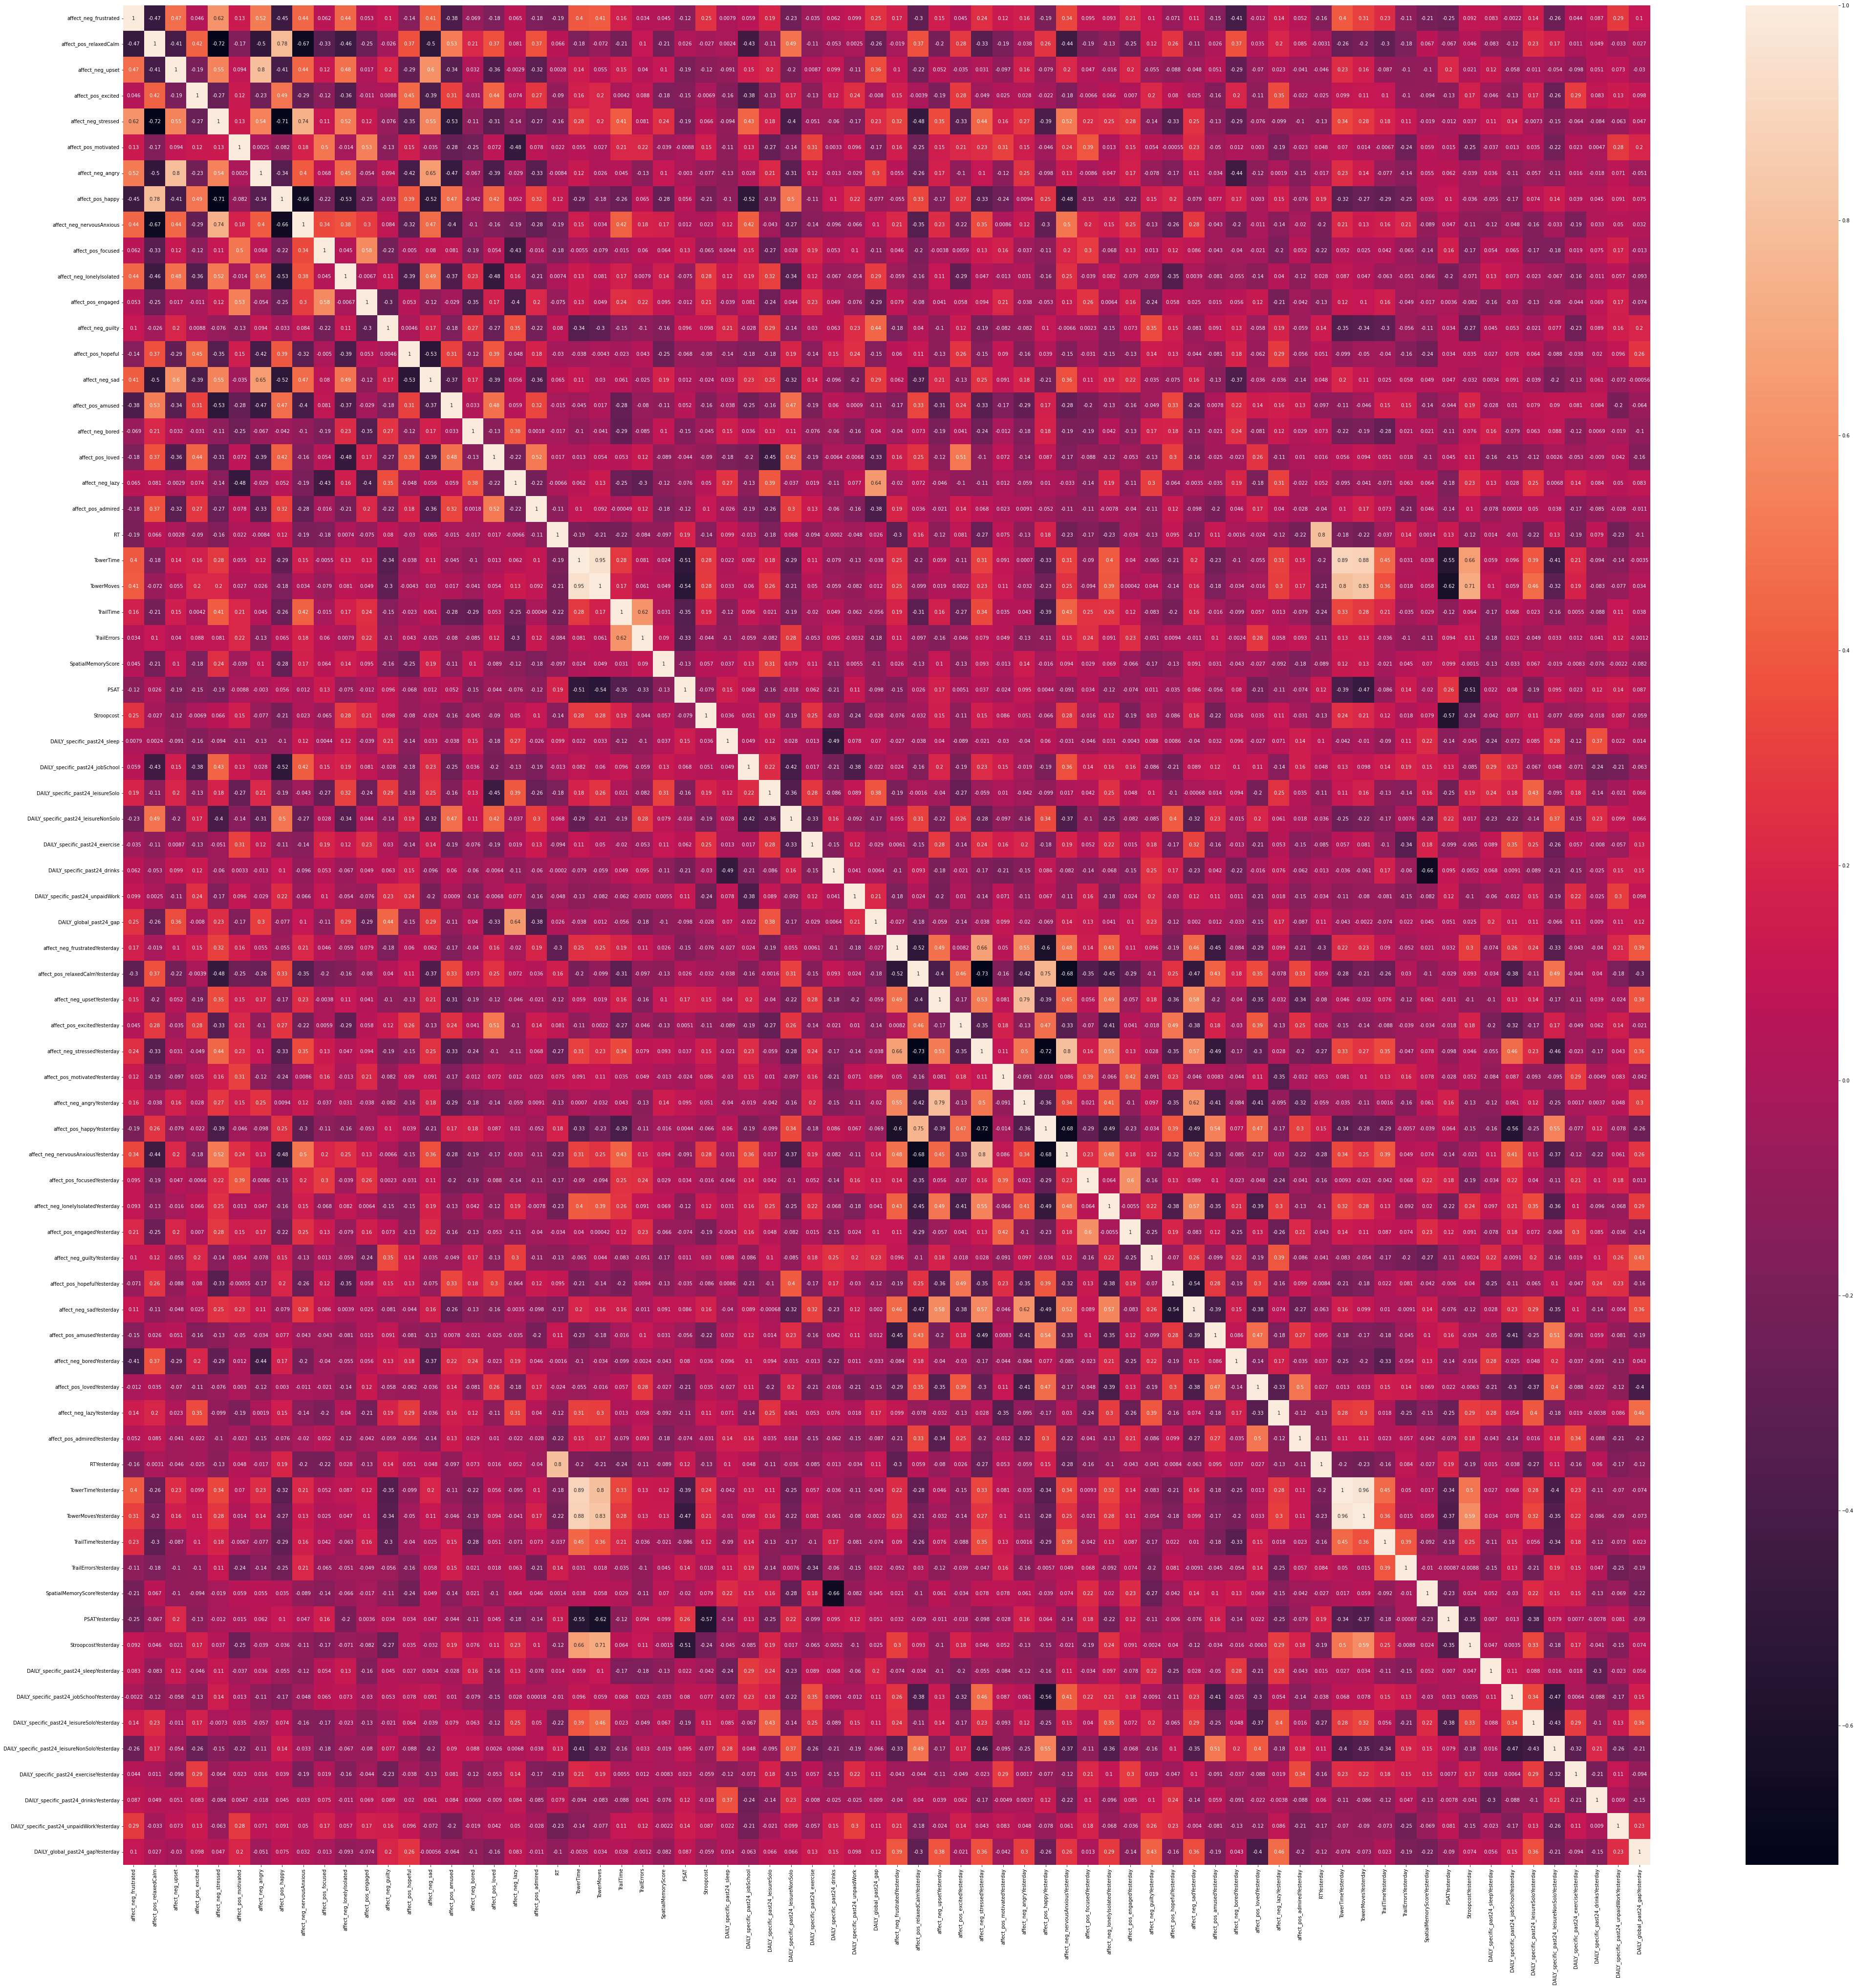

In [146]:
#creating pandas dictionary and dropping null values
df = pd.DataFrame(challenge1,columns = list(challenge1.keys()))
df = df.dropna(how='any',axis=0) 
#generating heatmap
corrMatrix = df.corr()
print(corrMatrix)
fig, ax = plt.subplots(figsize=(70,70))  
ax = sn.heatmap(corrMatrix, xticklabels=True, yticklabels=True,annot=True)

Multiple regression


In [ ]:
del challenge['Date']
w = list(challenge.keys())

for j in w:
  for i in range(len(challenge['affect_neg_angry'])):
    if challenge[j][i] == "null":
      challenge[j][i] = np.nan
    else:
      challenge[j][i] = float(challenge[j][i])

In [ ]:
challenge['Date'] = offtoside

In [ ]:
df = pd.DataFrame(challenge,columns = list(challenge.keys()))
df = df.set_index('Date')
df = df.dropna(how='any',axis=0) 
df = df.astype(float)

df

,affect_neg_frustrated,affect_pos_relaxedCalm,affect_neg_upset,affect_pos_excited,affect_neg_stressed,affect_pos_motivated,affect_neg_angry,affect_pos_happy,affect_neg_nervousAnxious,affect_pos_focused,affect_neg_lonelyIsolated,affect_pos_engaged,affect_neg_guilty,affect_pos_hopeful,affect_neg_sad,affect_pos_amused,affect_neg_bored,affect_pos_loved,affect_neg_lazy,affect_pos_admired,RT,TowerTime,TowerMoves,TrailTime,TrailErrors,SpatialMemoryScore,PSAT,Stroopcost,DAILY_specific_past24_sleep,DAILY_specific_past24_jobSchool,DAILY_specific_past24_leisureSolo,DAILY_specific_past24_leisureNonSolo,DAILY_specific_past24_exercise,DAILY_specific_past24_drinks,DAILY_specific_past24_unpaidWork,DAILY_global_past24_gap
Date,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2021-06-02,2.0,4.0,2.0,3.0,4.0,3.0,1.0,3.0,5.0,2.0,4.0,2.0,3.0,3.0,3.0,2.0,3.0,4.0,4.0,4.0,27035.300894,71.885390,60.0,14.029683,0.0,540.0,14.0,53.390962,8.0,5.0,4.0,3.5,0.5,0.0,2.0,20.0
2021-06-03,4.0,4.0,1.0,4.0,3.0,3.0,1.0,3.0,3.0,2.0,4.0,3.0,3.0,3.0,2.0,3.0,3.0,4.0,4.0,4.0,79507.920426,90.060206,77.0,13.977245,0.0,445.0,25.0,230.299550,8.2,3.0,3.6,3.0,1.2,0.0,0.5,20.0
2021-06-04,3.0,4.0,3.0,5.0,4.0,2.0,2.0,4.0,3.0,2.0,2.0,2.0,1.0,4.0,2.0,4.0,3.0,5.0,4.0,4.0,110397.594824,98.944397,81.0,12.506162,1.0,405.0,22.0,-113.289571,7.0,3.0,2.6,5.5,0.0,0.0,3.0,30.0
2021-06-07,2.0,2.0,2.0,1.0,5.0,3.0,1.0,3.0,5.0,3.0,4.0,3.0,3.0,2.0,3.0,3.0,1.0,5.0,4.0,4.0,218561.442292,124.775692,84.0,15.931311,0.0,370.0,29.0,-2.635705,7.0,3.5,2.0,2.0,1.0,0.0,2.1,10.0
2021-06-08,4.0,2.0,3.0,3.0,5.0,3.0,3.0,2.0,5.0,3.0,3.0,3.0,2.0,2.0,4.0,2.0,1.0,4.0,2.0,4.0,28654.326432,74.860992,54.0,17.534437,2.0,540.0,28.0,54.312623,8.5,5.5,2.0,3.5,1.0,0.0,3.0,20.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-08-22,2.0,5.0,1.0,4.0,2.0,3.0,1.0,5.0,2.0,3.0,2.0,3.0,3.0,3.0,3.0,3.0,2.0,5.0,2.0,4.0,563483.158291,15.782719,31.0,7.421570,0.0,540.0,28.0,-4.858726,8.0,1.1,1.0,8.0,0.7,0.0,2.1,10.0
2021-08-23,3.0,3.0,3.0,3.0,3.0,3.0,4.0,4.0,4.0,3.0,2.0,3.0,3.0,2.0,3.0,2.0,3.0,4.0,4.0,3.0,593538.380832,16.638607,31.0,8.812569,0.0,305.0,29.0,-1.277562,7.0,3.0,1.5,4.0,1.3,0.0,2.3,30.0
2021-08-26,2.0,2.0,3.0,3.0,5.0,4.0,2.0,3.0,5.0,3.0,2.0,3.0,3.0,3.0,3.0,3.0,4.0,4.0,2.0,4.0,719364.007403,14.919048,31.0,12.689639,0.0,425.0,30.0,-8.527195,6.0,4.5,2.0,3.0,1.0,0.0,2.5,20.0


In [ ]:
challenge.keys()

dict_keys(['affect_neg_frustrated', 'affect_pos_relaxedCalm', 'affect_neg_upset', 'affect_pos_excited', 'affect_neg_stressed', 'affect_pos_motivated', 'affect_neg_angry', 'affect_pos_happy', 'affect_neg_nervousAnxious', 'affect_pos_focused', 'affect_neg_lonelyIsolated', 'affect_pos_engaged', 'affect_neg_guilty', 'affect_pos_hopeful', 'affect_neg_sad', 'affect_pos_amused', 'affect_neg_bored', 'affect_pos_loved', 'affect_neg_lazy', 'affect_pos_admired', 'RT', 'TowerTime', 'TowerMoves', 'TrailTime', 'TrailErrors', 'SpatialMemoryScore', 'PSAT', 'Stroopcost', 'DAILY_specific_past24_sleep', 'DAILY_specific_past24_jobSchool', 'DAILY_specific_past24_leisureSolo', 'DAILY_specific_past24_leisureNonSolo', 'DAILY_specific_past24_exercise', 'DAILY_specific_past24_drinks', 'DAILY_specific_past24_unpaidWork', 'DAILY_global_past24_gap', 'Date'])

In [ ]:
X = df.drop(['affect_neg_frustrated', 'affect_pos_relaxedCalm', 'affect_neg_upset', 'affect_pos_excited', 'affect_neg_stressed', 'affect_pos_motivated', 'affect_neg_angry', 'affect_pos_happy', 'affect_neg_nervousAnxious', 'affect_pos_focused', 'affect_pos_engaged', 'affect_neg_guilty', 'affect_pos_hopeful', 'affect_neg_sad', 'affect_pos_amused', 'affect_neg_bored', 'affect_neg_lazy', 'affect_pos_admired', 'RT', 'TowerTime', 'TowerMoves', 'TrailTime', 'TrailErrors', 'SpatialMemoryScore', 'PSAT', 'Stroopcost', 'DAILY_specific_past24_sleep', 'DAILY_specific_past24_jobSchool', 'DAILY_specific_past24_exercise', 'DAILY_specific_past24_drinks', 'DAILY_specific_past24_leisureSolo','DAILY_specific_past24_unpaidWork', 'DAILY_global_past24_gap'],axis = 1)
Y1 = df[['DAILY_global_past24_gap']]
Y2 = df[['SpatialMemoryScore']]

X_train, X_test, y_train, y_test = train_test_split(X, Y1, test_size=0.20, random_state=1)
#X_train, X_test, y_train, y_test = train_test_split(X, Y2, test_size=0.20, random_state=1)

# create a Linear Regression model object
regression_model = LinearRegression()

# pass through the X_train & y_train data set
regression_model.fit(X_train, y_train)

LinearRegression()

In [ ]:
# let's grab the coefficient of our model and the intercept
intercept = regression_model.intercept_[0]
coefficent = regression_model.coef_[0][0]

print("The intercept for our model is {:.4}".format(intercept))
print('-'*100)

# loop through the dictionary and print the data
for coef in zip(X.columns, regression_model.coef_[0]):
    print("The Coefficient for {} is {:.2}".format(coef[0],coef[1]))

# Get multiple predictions
y_predict = regression_model.predict(X_test)

# Show the first 5 predictions
y_predict[:5]

The intercept for our model is 34.7
----------------------------------------------------------------------------------------------------
The Coefficient for affect_neg_lonelyIsolated is 1.2
The Coefficient for affect_pos_loved is -4.8
The Coefficient for DAILY_specific_past24_leisureNonSolo is -0.046


array([[18.69887116],
       [14.85433389],
       [17.52190894],
       [22.35840965],
       [22.40465935]])

In [ ]:
# define our intput
X2 = sm.add_constant(X)

# create a OLS model
model = sm.OLS(Y1, X2)

# fit the data
est = model.fit()

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/tsatools.py:117: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)


In [ ]:
# Run the White's test for heteroscedasticity
_, pval, __, f_pval = diag.het_white(est.resid, est.model.exog, retres = False)
print(pval, f_pval)
print('-'*100)

# print the results of the test
if pval > 0.05:
    print("For the White's Test")
    print("The p-value was {:.4}".format(pval))
    print("We fail to reject the null hypthoesis, so there is no heterosecdasticity. \n")
    
else:
    print("For the White's Test")
    print("The p-value was {:.4}".format(pval))
    print("We reject the null hypthoesis, so there is heterosecdasticity. \n")

# Run the Breusch-Pagan test
_, pval, __, f_pval = diag.het_breuschpagan(est.resid, est.model.exog)
print(pval, f_pval)
print('-'*100)

# print the results of the test
if pval > 0.05:
    print("For the Breusch-Pagan's Test")
    print("The p-value was {:.4}".format(pval))
    print("We fail to reject the null hypthoesis, so there is no heterosecdasticity.")

else:
    print("For the Breusch-Pagan's Test")
    print("The p-value was {:.4}".format(pval))
    print("We reject the null hypthoesis, so there is heterosecdasticity.")

0.2983851014545502 0.31175409578399715
----------------------------------------------------------------------------------------------------
For the White's Test
The p-value was 0.2984
We fail to reject the null hypthoesis, so there is no heterosecdasticity. 

0.10947639257430278 0.111360925380891
----------------------------------------------------------------------------------------------------
For the Breusch-Pagan's Test
The p-value was 0.1095
We fail to reject the null hypthoesis, so there is no heterosecdasticity.


The number of lags will be 10
----------------------------------------------------------------------------------------------------
The lowest p-value found was 0.5642
We fail to reject the null hypthoesis, so there is no autocorrelation.
----------------------------------------------------------------------------------------------------


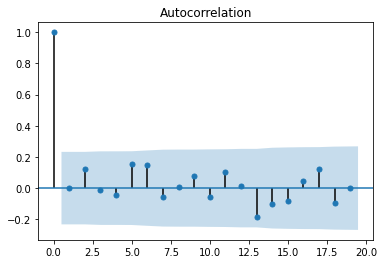

In [ ]:
# test for autocorrelation
from statsmodels.stats.stattools import durbin_watson

# calculate the lag, optional
lag = min(10, (len(X)//5))
print('The number of lags will be {}'.format(lag))
print('-'*100)

# run the Ljung-Box test for no autocorrelation of residuals
# test_results = diag.acorr_breusch_godfrey(est, nlags = lag, store = True)
test_results = diag.acorr_ljungbox(est.resid, lags = lag)

# grab the p-values and the test statistics
ibvalue, p_val = test_results

# print the results of the test
if min(p_val) > 0.05:
    print("The lowest p-value found was {:.4}".format(min(p_val)))
    print("We fail to reject the null hypthoesis, so there is no autocorrelation.")
    print('-'*100)
else:
    print("The lowest p-value found was {:.4}".format(min(p_val)))
    print("We reject the null hypthoesis, so there is autocorrelation.")
    print('-'*100)

# plot autocorrelation
sm.graphics.tsa.plot_acf(est.resid)
plt.show()

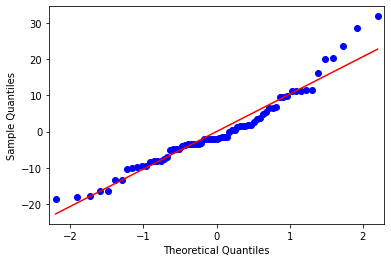

The mean of the residuals is -2.052e-15


In [ ]:
import pylab

# check for the normality of the residuals
sm.qqplot(est.resid, line='s')
pylab.show()

# also check that the mean of the residuals is approx. 0.
mean_residuals = sum(est.resid)/ len(est.resid)
print("The mean of the residuals is {:.4}".format(mean_residuals))

In [ ]:
import math
# calculate the mean squared error
model_mse = mean_squared_error(y_test, y_predict)

# calculate the mean absolute error
model_mae = mean_absolute_error(y_test, y_predict)

# calulcate the root mean squared error
model_rmse =  math.sqrt(model_mse)

# display the output
print("MSE {:.3}".format(model_mse))
print("MAE {:.3}".format(model_mae))
print("RMSE {:.3}".format(model_rmse))

MSE 1.23e+02
MAE 8.8
RMSE 11.1


In [ ]:
model_r2 = r2_score(y_test, y_predict)
print("R2: {:.2}".format(model_r2))

R2: -0.092


In [ ]:
est.conf_int()


,0,1
const,14.627457,55.419475
affect_neg_lonelyIsolated,-1.526596,4.429927
affect_pos_loved,-8.861618,-0.570285
DAILY_specific_past24_leisureNonSolo,-1.328198,1.092866


In [ ]:
est.pvalues


const                                   0.001046
affect_neg_lonelyIsolated               0.334105
affect_pos_loved                        0.026393
DAILY_specific_past24_leisureNonSolo    0.846751
dtype: float64

In [ ]:
print(est.summary())


                               OLS Regression Results                              
Dep. Variable:     DAILY_global_past24_gap   R-squared:                       0.141
Model:                                 OLS   Adj. R-squared:                  0.103
Method:                      Least Squares   F-statistic:                     3.678
Date:                     Mon, 07 Feb 2022   Prob (F-statistic):             0.0163
Time:                             20:28:41   Log-Likelihood:                -266.67
No. Observations:                       71   AIC:                             541.3
Df Residuals:                           67   BIC:                             550.4
Df Model:                                3                                         
Covariance Type:                 nonrobust                                         
                                           coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------